# Preparation

### Loading dependencies

In [1]:
# Libraries 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tf_utils
from time import time
from datetime import date
import json
import pathlib
import albumentations as A

### Setting main parameters and seeds

In [3]:
# Parameters
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123
FPATH = 'D:/Master thesis/saved_models/'

tf.random.set_seed(SEED)
np.random.seed(SEED)

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

### Loading datasets

In [132]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
kaggle_ds = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = kaggle_ds.class_names
no_classes = len(class_names)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(kaggle_ds, train_part, valid_part, test_part, seed=SEED)
print(f'Batches ({BATCH_SIZE} images per batch) in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
kaggle_ds = kaggle_ds.map(tf_utils.normalize)
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize)
test_ds = test_ds.map(tf_utils.normalize)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Batches (32 images per batch) in subsets:
Train: 219
Validation: 47
Test: 48


# Training

### Importing the model

#### Inception

In [21]:
# Constructing a model
name = 'InceptionV3'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dropout(rate=0.4, seed=SEED))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

#### VGG

In [17]:
# Constructing a model
name = 'VGG19'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### ResNet

In [4]:
# Constructing a model
name = 'ResNet50'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### MobileNet

In [5]:
# Constructing a model
name = 'MobileNet'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Compiling the model and fitting

In [5]:
# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 75)                75075     
                                                                 
Total params: 25,711,787
Trainable params: 25,658,667
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

training_date = date.today()
model_dir_name = f'{model.name}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name)
model_dir_name += str(ctr)

print(model_dir_name)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model',
        monitor='val_accuracy',
        save_best_only=True
    )
]

t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds),
    callbacks=callbacks
)

training_time = time() - t0

ResNet50_(2023-04-13)_1
Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 1.8885 - accuracy: 0.5168

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


219/219 [==============================] - 547s 2s/step - loss: 1.8885 - accuracy: 0.5168 - val_loss: 5.7383 - val_accuracy: 0.0175
Epoch 2/100
217/219 [============================>.] - ETA: 3s - loss: 0.6529 - accuracy: 0.8026

KeyboardInterrupt: 

### Evaluation and saving

In [20]:
model = tf.keras.models.load_model(f'{FPATH}/{model_dir_name}/model')

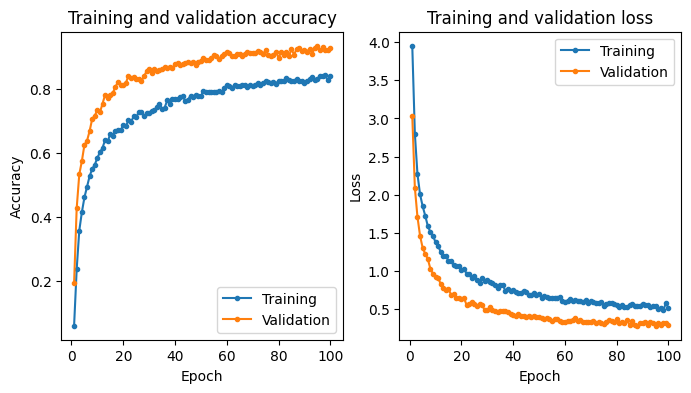

In [21]:
tf_utils.plot_history(history)

tf_utils.save_json(f'{FPATH}/{model_dir_name}/history.json', history.history)
#json.dump(history.history, open(f'{FPATH}/{model_dir_name}/history.json', 'w'))

In [22]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 80s 439ms/step - loss: 0.3065 - accuracy: 0.9199
Kaggle set evaluation: 
Test loss: 0.30653977394104004
Test accuracy: 0.919921875


1/1 [==============================] - 1s 1s/step


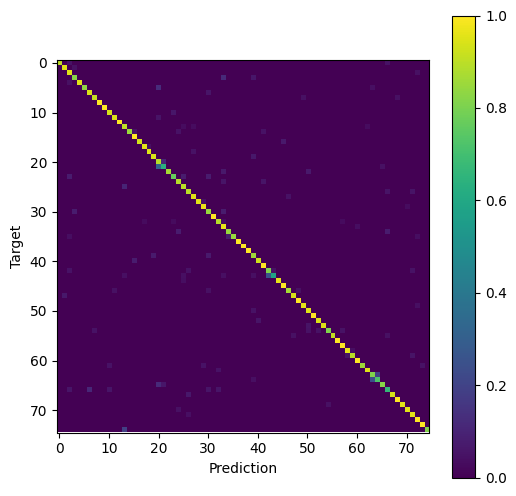

In [23]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m,figsize=(6,6))
plt.show()

In [24]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 8s 381ms/step - loss: 1.0195 - accuracy: 0.7029
Nature set evaluation: 
Test loss: 1.0194560289382935
Test accuracy: 0.7028985619544983


1/1 [==============================] - 4s 4s/step


d:\Master thesis\MasterThesis-1\tf_utils.py:182: RuntimeWarning: invalid value encountered in divide
  mat[i, :] /= normalization[i]


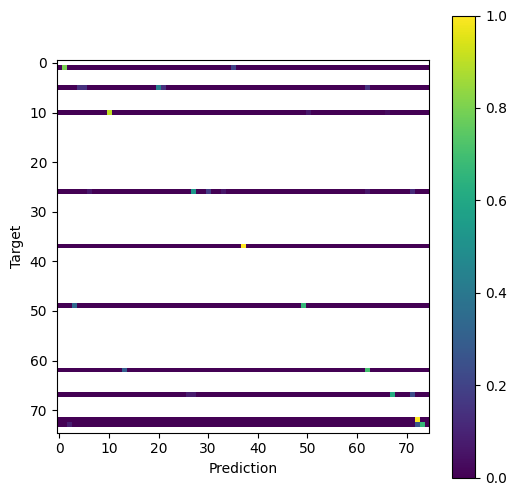

In [25]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m,figsize=(6,6))
plt.show()

In [26]:
# Evaluating inference time
t0 = time()
model.predict(kaggle_ds)
t1 = time()
inf_time = (t1 - t0) * 1000 / 10033

314/314 [==============================] - 142s 437ms/step


In [27]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'batch_size': BATCH_SIZE,
    'seed': SEED,
    'epochs': EPOCHS,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'inference_time': inf_time,
    'comment': '',
    'test_confusion': m.tolist(),
    'nature_confusion': nature_m.tolist()
    }

tf_utils.save_json(f'{FPATH}/{model_dir_name}/info.json', info)
#json.dump(info, open(f'{FPATH}/{model_dir_name}/info.json', 'w'))

# Influence of image quality

### Preparing functions required for transforming images

In [4]:
# Auxiliary functions
from tf_utils import transform_image, prepare_mapping, set_shapes

def test_transformed(model_paths, transforms, dataset, avg_amount=10):
    '''
    Performs series of tests of tensroflow models on given dataset transformed with some albumentations. For every model
    and every transformation results is averaged over `avg_amount` runs.

    Arguments:
        `model_paths`: list of paths to directories of models on which tests will be performed
        `transforms`: dictionary that should contain these three items:

            * list of albumentations to apply with key `list`\n
            * list of corresponding parameters controlling transformation with key `parameters`\n
            * name of transformation with key `name`
        `dataset`: tensorflow dataset of images on which models will be tested
        `avg_amount`: number of runs over which results will be averaged for every pair (model, transformation)

    Returns:
        `df`: pandas DataFrame with columns containing model's dictionary name, model's name, transformation parameter, loss and accuracy
    '''
    rows = []

    for path in model_paths:
        info = tf_utils.load_json(str(path) + '/info.json')
        np.random.seed(info['seed'])
        tf.random.set_seed(info['seed'])

        model = tf.keras.models.load_model(str(path) + '/model')
        print(f'Testing {path.name} in progress:')

        for itr, transform in enumerate(transforms['list']):
            print(f'\tTransform {itr+1}/{len(transforms["list"])}:')
            loss = 0
            accuracy = 0
            for itr2 in range(avg_amount):
                print(f'\t\t{itr2/avg_amount*100 : 3.0f}%', end='\r')

                tmp_ds = dataset.map(prepare_mapping(transform)).prefetch(tf.data.AUTOTUNE)
                tmp_ds = tmp_ds.map(set_shapes()).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

                tmp_loss, tmp_acc = model.evaluate(tmp_ds, verbose=False)
                loss += tmp_loss
                accuracy += tmp_acc

            print(f'\t\tLoss: {loss / avg_amount}, Accuracy: {accuracy / avg_amount}')
            rows.append({
                'saved_model': path.name,
                'model': model.name,
                'loss': loss / avg_amount,
                'accuracy': accuracy / avg_amount,
                transforms['name']: transforms['parameters'][itr]
            })
        
    df = pd.DataFrame(rows)
    return df

### Finding and choosing models

In [5]:
# Listing available models
model_paths = list(pathlib.Path(FPATH).glob('*'))
for i, p in enumerate(model_paths):
    info = tf_utils.load_json(str(p) + '/info.json')
    print(i, p.name, info['test_accuracy'], info['nature_accuracy'])

selected = model_paths[0:3] + model_paths[4:7] + model_paths[7:10]
selected

0 InceptionV3_(2023-04-07)_0 0.974609375 0.8695652484893799
1 InceptionV3_(2023-04-08)_0 0.9791666865348816 0.8550724983215332
2 InceptionV3_(2023-04-08)_1 0.9798177480697632 0.8405797481536865
3 MobileNetV2_(2023-03-24)_0 0.9596354365348816 0.8115942478179932
4 MobileNet_(2023-03-23)_0 0.9752604365348816 0.8333333730697632
5 MobileNet_(2023-04-09)_0 0.9778646230697632 0.8695652484893799
6 MobileNet_(2023-04-09)_1 0.982421875 0.9130434989929199
7 ResNet50v2_(2023-03-25)_0 0.9654948115348816 0.760869562625885
8 ResNet50v2_(2023-04-09)_0 0.9713541865348816 0.782608687877655
9 ResNet50v2_(2023-04-10)_0 0.9739583730697632 0.7898550629615784
10 ResNet_(2023-03-22)_1 0.9680989980697632 0.782608687877655
11 VGG16_(2023-03-20)_0 0.9420573115348816 0.7681159377098083
12 VGG16_(2023-04-10)_0 0.9466146230697632 0.782608687877655
13 VGG16_(2023-04-10)_1 0.9427083730697632 0.7898550629615784
14 VGG19_(2023-03-20)_0 0.9173177480697632 0.760869562625885
15 VGG19_(2023-04-11)_0 0.93359375 0.7101449370

[WindowsPath('D:/Master thesis/saved_models/InceptionV3_(2023-04-07)_0'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_(2023-04-08)_0'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_(2023-04-08)_1'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_(2023-03-23)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_(2023-04-09)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_(2023-04-09)_1'),
 WindowsPath('D:/Master thesis/saved_models/ResNet50v2_(2023-03-25)_0'),
 WindowsPath('D:/Master thesis/saved_models/ResNet50v2_(2023-04-09)_0'),
 WindowsPath('D:/Master thesis/saved_models/ResNet50v2_(2023-04-10)_0')]

### Loading the testing dataset

In [6]:
# Loading the dataset
ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=None
)

ds = ds.map(tf_utils.normalize).prefetch(tf.data.AUTOTUNE)

Found 138 files belonging to 75 classes.


### Running tests

#### Brightness

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 70.5132908821106, Accuracy: 1.7391304671764374
	Transform 2/19:
		Loss: 28.653287649154663, Accuracy: 5.579710006713867
	Transform 3/19:
		Loss: 15.92212700843811, Accuracy: 6.9565218687057495
	Transform 4/19:
		Loss: 11.485658288002014, Accuracy: 7.536231875419617
	Transform 5/19:
		Loss: 8.49070531129837, Accuracy: 8.115941882133484
	Transform 6/19:
		Loss: 7.312748730182648, Accuracy: 8.333333134651184
	Transform 7/19:
		Loss: 6.754623055458069, Accuracy: 8.47826063632965
	Transform 8/19:
		Loss: 6.332069098949432, Accuracy: 8.695651888847351
	Transform 9/19:
		Loss: 6.0786784291267395, Accuracy: 8.623188138008118
	Transform 10/19:
		Loss: 5.897654473781586, Accuracy: 8.695651888847351
	Transform 11/19:
		Loss: 5.995318353176117, Accuracy: 8.623188138008118
	Transform 12/19:
		Loss: 6.269143223762512, Accuracy: 8.623188138008118
	Transform 13/19:
		Loss: 7.017915487289429, Accuracy: 8.405796885490417
	Transform

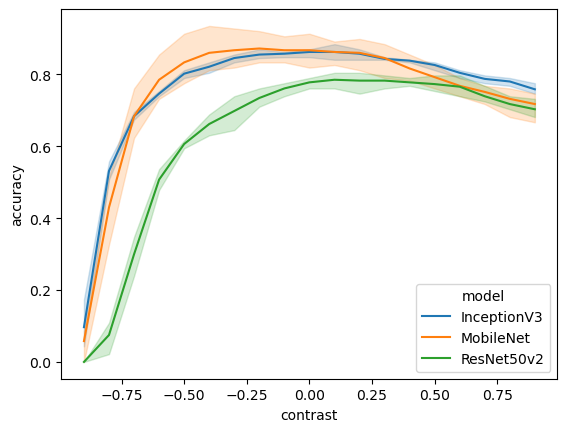

In [40]:
params = np.arange(-0.9, 1, 0.1)
transforms_list = [A.RandomBrightnessContrast(brightness_limit=(i,i), contrast_limit=(0,0), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'brightness'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()
df.to_csv(transforms['name']+'.csv')


#### Contrast

In [ ]:
params = np.arange(-0.9, 1, 0.1)
transforms_list = [A.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(i,i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'contrast'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()
df.to_csv(transforms['name']+'.csv')

#### Gaussian noise

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.6031642019748688, Accuracy: 0.8768115997314453
	Transform 2/19:
		Loss: 0.6108841478824616, Accuracy: 0.8840579926967621
	Transform 3/19:
		Loss: 0.6407016694545746, Accuracy: 0.8731883943080903
	Transform 4/19:
		Loss: 0.6664171338081359, Accuracy: 0.8630434572696686
	Transform 5/19:
		Loss: 0.7269252479076386, Accuracy: 0.8536231637001037
	Transform 6/19:
		Loss: 0.8416442692279815, Accuracy: 0.8384057760238648
	Transform 7/19:
		Loss: 1.0536759316921234, Accuracy: 0.810869550704956
	Transform 8/19:
		Loss: 1.2296832919120788, Accuracy: 0.786956512928009
	Transform 9/19:
		Loss: 1.504951786994934, Accuracy: 0.7695652127265931
	Transform 10/19:
		Loss: 1.794931137561798, Accuracy: 0.7420289874076843
	Transform 11/19:
		Loss: 2.0523473739624025, Accuracy: 0.7057971119880676
	Transform 12/19:
		Loss: 2.4808592557907105, Accuracy: 0.6137680947780609
	Transform 13/19:
		Loss: 3.2801411151885986, Accuracy: 0.4557971

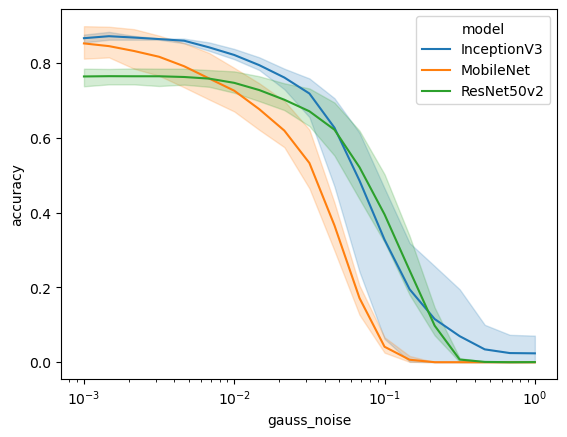

In [142]:
params = np.logspace(-3, 0, 19)
transforms_list = [A.GaussNoise(var_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_noise'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

df.to_csv(transforms['name']+'.csv')

#### Gamma

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 9.556099891662598, Accuracy: 0.07246376574039459
	Transform 2/19:
		Loss: 9.513021183013915, Accuracy: 0.07246376574039459
	Transform 3/19:
		Loss: 9.415106296539307, Accuracy: 0.07246376574039459
	Transform 4/19:
		Loss: 9.136446952819824, Accuracy: 0.07246376574039459
	Transform 5/19:
		Loss: 6.619854402542114, Accuracy: 0.239130437374115
	Transform 6/19:
		Loss: 3.8229230403900147, Accuracy: 0.4275362193584442
	Transform 7/19:
		Loss: 2.1977416038513184, Accuracy: 0.6376811861991882
	Transform 8/19:
		Loss: 1.2101887583732605, Accuracy: 0.7898550629615784
	Transform 9/19:
		Loss: 0.8068097233772278, Accuracy: 0.8333333134651184
	Transform 10/19:
		Loss: 0.5897654473781586, Accuracy: 0.8695651888847351
	Transform 11/19:
		Loss: 0.5364249467849731, Accuracy: 0.8695651888847351
	Transform 12/19:
		Loss: 0.7924931704998016, Accuracy: 0.7898550629615784
	Transform 13/19:
		Loss: 2.089662528038025, Accuracy: 0.594202

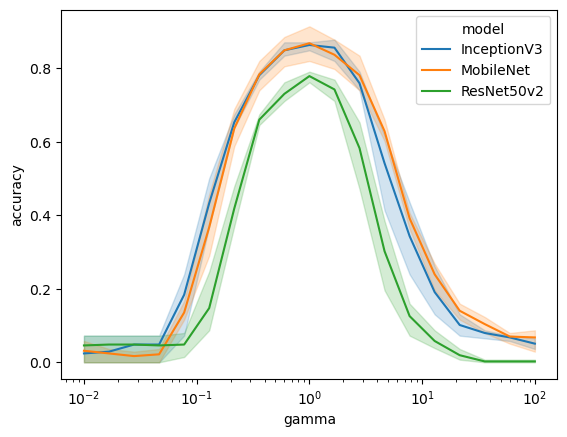

In [47]:
params = np.logspace(0,4,19)
transforms_list = [A.RandomGamma(gamma_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gamma'
}

df = test_transformed(selected, transforms, nature_ds, 10)

df[transforms['name']] /= 100 # Actual gamma parameter is 100 times smaller than the one passed to albumentations

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

df.to_csv(transforms['name']+'.csv')

#### Image compression

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:


c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 3.7743403911590576, Accuracy: 0.47101449966430664
	Transform 2/19:
		Loss: 3.7096659421920775, Accuracy: 0.49275362491607666
	Transform 3/19:
		Loss: 2.142667818069458, Accuracy: 0.6449275612831116
	Transform 4/19:
		Loss: 1.4956362843513489, Accuracy: 0.717391312122345
	Transform 5/19:
		Loss: 1.404713797569275, Accuracy: 0.7246376872062683
	Transform 6/19:
		Loss: 1.139083731174469, Accuracy: 0.7898550629615784
	Transform 7/19:
		Loss: 1.0577760338783264, Accuracy: 0.8188405632972717
	Transform 8/19:
		Loss: 0.9651691675186157, Accuracy: 0.8478260636329651
	Transform 9/19:
		Loss: 0.9691285610198974, Accuracy: 0.8405796885490417
	Transform 10/19:
		Loss: 0.8911582589149475, Accuracy: 0.8333333134651184
	Transform 11/19:
		Loss: 0.8451422035694123, Accuracy: 0.8478260636329651
	Transform 12/19:
		Loss: 0.8879782557487488, Accuracy: 0.8333333134651184
	Transform 13/19:
		Loss: 0.8442875027656556, Accuracy: 0.8478260636329651
	Transform 14/19:
		Loss: 0.7761738061904907, Accurac

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 3.110553574562073, Accuracy: 0.5289855003356934
	Transform 2/19:
		Loss: 3.1600453853607178, Accuracy: 0.5507246255874634
	Transform 3/19:
		Loss: 2.236571478843689, Accuracy: 0.6884058117866516
	Transform 4/19:
		Loss: 1.5221626996994018, Accuracy: 0.7463768124580383
	Transform 5/19:
		Loss: 1.5007379293441772, Accuracy: 0.7463768124580383
	Transform 6/19:
		Loss: 1.2093814134597778, Accuracy: 0.7681159377098083
	Transform 7/19:
		Loss: 1.1166515588760375, Accuracy: 0.782608687877655
	Transform 8/19:
		Loss: 1.0311721920967103, Accuracy: 0.7971014380455017
	Transform 9/19:
		Loss: 1.019221556186676, Accuracy: 0.8115941882133484
	Transform 10/19:
		Loss: 1.040340793132782, Accuracy: 0.7971014380455017
	Transform 11/19:
		Loss: 0.9614830732345581, Accuracy: 0.804347813129425
	Transform 12/19:
		Loss: 0.9209746301174164, Accuracy: 0.8188405632972717
	Transform 13/19:
		Loss: 0.9137182295322418, Accuracy: 0.8115941882133484
	Transform 14/19:
		Loss: 0.8860437214374542, Accuracy: 0

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 2.9184216976165773, Accuracy: 0.5362318754196167
	Transform 2/19:
		Loss: 2.667151141166687, Accuracy: 0.5652173757553101
	Transform 3/19:
		Loss: 1.6588927507400513, Accuracy: 0.7246376872062683
	Transform 4/19:
		Loss: 0.9297120690345764, Accuracy: 0.7753623127937317
	Transform 5/19:
		Loss: 0.8815710723400116, Accuracy: 0.7898550629615784
	Transform 6/19:
		Loss: 0.8378146052360534, Accuracy: 0.804347813129425
	Transform 7/19:
		Loss: 0.7573856830596923, Accuracy: 0.8115941882133484
	Transform 8/19:
		Loss: 0.6567678391933441, Accuracy: 0.8260869383811951
	Transform 9/19:
		Loss: 0.6368393659591675, Accuracy: 0.8333333134651184
	Transform 10/19:
		Loss: 0.628609836101532, Accuracy: 0.8333333134651184
	Transform 11/19:
		Loss: 0.6303203165531158, Accuracy: 0.8405796885490417
	Transform 12/19:
		Loss: 0.7029922306537628, Accuracy: 0.8260869383811951
	Transform 13/19:
		Loss: 0.6699774026870727, Accuracy: 0.8405796885490417
	Transform 14/19:
		Loss: 0.6533527672290802, Accuracy

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 6.533331346511841, Accuracy: 0.3188405930995941
	Transform 2/19:
		Loss: 6.111760473251342, Accuracy: 0.3695652186870575
	Transform 3/19:
		Loss: 2.6315871715545653, Accuracy: 0.5652173757553101
	Transform 4/19:
		Loss: 1.860591721534729, Accuracy: 0.6449275612831116
	Transform 5/19:
		Loss: 1.685430681705475, Accuracy: 0.6884058117866516
	Transform 6/19:
		Loss: 1.475510847568512, Accuracy: 0.7536231875419617
	Transform 7/19:
		Loss: 1.4808493494987487, Accuracy: 0.7681159377098083
	Transform 8/19:
		Loss: 1.275518798828125, Accuracy: 0.782608687877655
	Transform 9/19:
		Loss: 1.3580866813659669, Accuracy: 0.7898550629615784
	Transform 10/19:
		Loss: 1.3332672238349914, Accuracy: 0.804347813129425
	Transform 11/19:
		Loss: 1.314699161052704, Accuracy: 0.7971014380455017
	Transform 12/19:
		Loss: 1.3160463213920592, Accuracy: 0.7898550629615784
	Transform 13/19:
		Loss: 1.2779350638389588, Accuracy: 0.8115941882133484
	Transform 14/19:
		Loss: 1.2012779355049132, Accuracy: 0.81

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 4.139761447906494, Accuracy: 0.4057970941066742
	Transform 2/19:
		Loss: 4.051486015319824, Accuracy: 0.43478259444236755
	Transform 3/19:
		Loss: 2.7687346935272217, Accuracy: 0.54347825050354
	Transform 4/19:
		Loss: 1.757431733608246, Accuracy: 0.6449275612831116
	Transform 5/19:
		Loss: 1.6287622570991516, Accuracy: 0.6884058117866516
	Transform 6/19:
		Loss: 1.2334384799003602, Accuracy: 0.739130437374115
	Transform 7/19:
		Loss: 1.122394585609436, Accuracy: 0.7318840622901917
	Transform 8/19:
		Loss: 0.9457767009735107, Accuracy: 0.7318840622901917
	Transform 9/19:
		Loss: 0.9637794613838195, Accuracy: 0.760869562625885
	Transform 10/19:
		Loss: 0.9608653306961059, Accuracy: 0.7536231875419617
	Transform 11/19:
		Loss: 0.9774491310119628, Accuracy: 0.7753623127937317
	Transform 12/19:
		Loss: 0.8858661770820617, Accuracy: 0.7898550629615784
	Transform 13/19:
		Loss: 0.8823930263519287, Accuracy: 0.782608687877655
	Transform 14/19:
		Loss: 0.832793128490448, Accuracy: 0.79

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 6.2832396030426025, Accuracy: 0.37681159377098083
	Transform 2/19:
		Loss: 5.6862575054168705, Accuracy: 0.4202898442745209
	Transform 3/19:
		Loss: 2.3418842554092407, Accuracy: 0.695652186870575
	Transform 4/19:
		Loss: 1.2216484189033507, Accuracy: 0.8115941882133484
	Transform 5/19:
		Loss: 1.1154887318611144, Accuracy: 0.7971014380455017
	Transform 6/19:
		Loss: 0.7418771684169769, Accuracy: 0.8260869383811951
	Transform 7/19:
		Loss: 0.8029170334339142, Accuracy: 0.8550724387168884
	Transform 8/19:
		Loss: 0.6233790338039398, Accuracy: 0.8695651888847351
	Transform 9/19:
		Loss: 0.6603474378585815, Accuracy: 0.8695651888847351
	Transform 10/19:
		Loss: 0.6308423638343811, Accuracy: 0.8478260636329651
	Transform 11/19:
		Loss: 0.636926531791687, Accuracy: 0.8550724387168884
	Transform 12/19:
		Loss: 0.5994519650936126, Accuracy: 0.8768116235733032
	Transform 13/19:
		Loss: 0.7191494107246399, Accuracy: 0.8478260636329651
	Transform 14/19:
		Loss: 0.723377811908722, Accurac

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 7.654739475250244, Accuracy: 0.3840579688549042
	Transform 2/19:
		Loss: 6.864834880828857, Accuracy: 0.3913043439388275
	Transform 3/19:
		Loss: 3.1781890630722045, Accuracy: 0.5942028760910034
	Transform 4/19:
		Loss: 2.2732815027236937, Accuracy: 0.6594203114509583
	Transform 5/19:
		Loss: 2.3231383562088013, Accuracy: 0.6594203114509583
	Transform 6/19:
		Loss: 2.191530871391296, Accuracy: 0.6884058117866516
	Transform 7/19:
		Loss: 2.1447463512420653, Accuracy: 0.7246376872062683
	Transform 8/19:
		Loss: 2.150668430328369, Accuracy: 0.6884058117866516
	Transform 9/19:
		Loss: 2.0915114879608154, Accuracy: 0.717391312122345
	Transform 10/19:
		Loss: 2.014137101173401, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.9843405485153198, Accuracy: 0.739130437374115
	Transform 12/19:
		Loss: 2.0175733089447023, Accuracy: 0.739130437374115
	Transform 13/19:
		Loss: 1.9635095596313477, Accuracy: 0.7318840622901917
	Transform 14/19:
		Loss: 1.9244464635849, Accuracy: 0.73913

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 5.266203594207764, Accuracy: 0.47826087474823
	Transform 2/19:
		Loss: 4.944540500640869, Accuracy: 0.47101449966430664
	Transform 3/19:
		Loss: 2.8632341623306274, Accuracy: 0.695652186870575
	Transform 4/19:
		Loss: 2.302327871322632, Accuracy: 0.739130437374115
	Transform 5/19:
		Loss: 2.3709423303604127, Accuracy: 0.7753623127937317
	Transform 6/19:
		Loss: 2.223936414718628, Accuracy: 0.782608687877655
	Transform 7/19:
		Loss: 2.2130455017089843, Accuracy: 0.7753623127937317
	Transform 8/19:
		Loss: 2.092419385910034, Accuracy: 0.7753623127937317
	Transform 9/19:
		Loss: 2.2258508920669557, Accuracy: 0.7753623127937317
	Transform 10/19:
		Loss: 2.17809374332428, Accuracy: 0.7753623127937317
	Transform 11/19:
		Loss: 2.1583085536956785, Accuracy: 0.7753623127937317
	Transform 12/19:
		Loss: 2.165409517288208, Accuracy: 0.7753623127937317
	Transform 13/19:
		Loss: 2.114455008506775, Accuracy: 0.7898550629615784
	Transform 14/19:
		Loss: 2.1228516578674315, Accuracy: 0.775362

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 5.272617959976197, Accuracy: 0.5869565010070801
	Transform 2/19:
		Loss: 4.956619691848755, Accuracy: 0.5797101259231567
	Transform 3/19:
		Loss: 3.400480628013611, Accuracy: 0.695652186870575
	Transform 4/19:
		Loss: 3.003540277481079, Accuracy: 0.7536231875419617
	Transform 5/19:
		Loss: 2.967933487892151, Accuracy: 0.7681159377098083
	Transform 6/19:
		Loss: 2.729032301902771, Accuracy: 0.7681159377098083
	Transform 7/19:
		Loss: 2.5887211561203003, Accuracy: 0.7681159377098083
	Transform 8/19:
		Loss: 2.5107239484786987, Accuracy: 0.7681159377098083
	Transform 9/19:
		Loss: 2.5355926036834715, Accuracy: 0.760869562625885
	Transform 10/19:
		Loss: 2.4823330640792847, Accuracy: 0.760869562625885
	Transform 11/19:
		Loss: 2.4841403007507323, Accuracy: 0.760869562625885
	Transform 12/19:
		Loss: 2.455230450630188, Accuracy: 0.7681159377098083
	Transform 13/19:
		Loss: 2.477388858795166, Accuracy: 0.7753623127937317
	Transform 14/19:
		Loss: 2.500239300727844, Accuracy: 0.775362

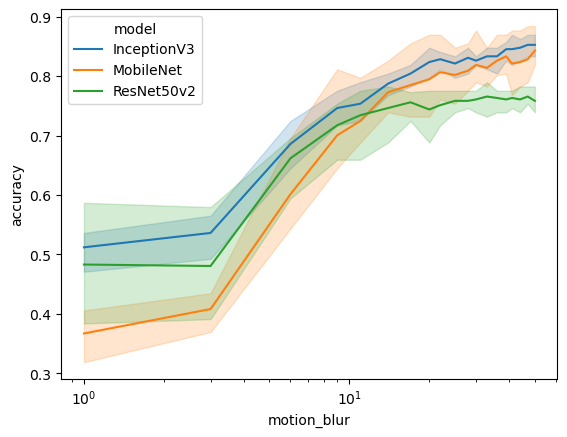

In [148]:
params = np.linspace(1,50,19).astype(int)
transforms_list = [A.ImageCompression(quality_lower=i, quality_upper=i, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'img_compression'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(transforms['name']+'.csv')

#### Gaussian blur

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.5897654354572296, Accuracy: 0.8695651888847351
	Transform 2/19:
		Loss: 0.6692057847976685, Accuracy: 0.8550724387168884
	Transform 3/19:
		Loss: 0.7896425008773804, Accuracy: 0.8405796885490417
	Transform 4/19:
		Loss: 1.0494293093681335, Accuracy: 0.8188405632972717
	Transform 5/19:
		Loss: 1.2758109807968139, Accuracy: 0.782608687877655
	Transform 6/19:
		Loss: 1.4962961554527283, Accuracy: 0.739130437374115
	Transform 7/19:
		Loss: 1.8432701110839844, Accuracy: 0.6739130616188049
	Transform 8/19:
		Loss: 2.4035842418670654, Accuracy: 0.5942028760910034
	Transform 9/19:
		Loss: 3.0523616790771486, Accuracy: 0.52173912525177
	Transform 10/19:
		Loss: 3.72802894115448, Accuracy: 0.47101449966430664
	Transform 11/19:
		Loss: 4.479701519012451, Accuracy: 0.3333333432674408
	Transform 12/19:
		Loss: 5.346041011810303, Accuracy: 0.2028985470533371
	Transform 13/19:
		Loss: 6.283002185821533, Accuracy: 0.08695652335

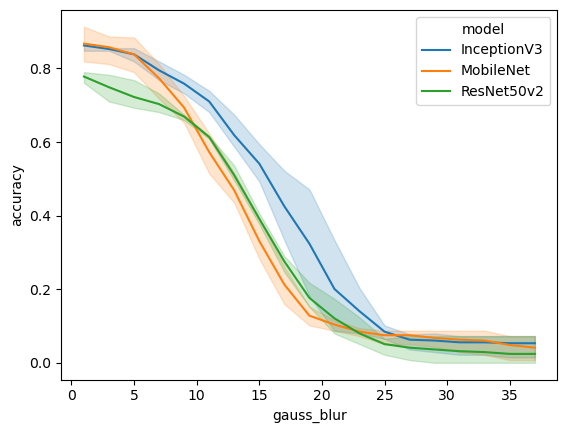

In [174]:
params = np.arange(1, 39, 2)
transforms_list = [A.GaussianBlur(blur_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_blur'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(transforms['name']+'.csv')

#### Motion blur

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.6211290478706359, Accuracy: 0.8615941882133484
	Transform 2/19:
		Loss: 0.801071721315384, Accuracy: 0.8413043260574341
	Transform 3/19:
		Loss: 1.3576412916183471, Accuracy: 0.7746376752853393
	Transform 4/19:
		Loss: 2.238227701187134, Accuracy: 0.6449275493621827
	Transform 5/19:
		Loss: 3.1095695972442625, Accuracy: 0.556521725654602
	Transform 6/19:
		Loss: 4.2695060014724735, Accuracy: 0.4420289874076843
	Transform 7/19:
		Loss: 5.17979097366333, Accuracy: 0.36521739363670347
	Transform 8/19:
		Loss: 5.868490934371948, Accuracy: 0.31739130318164827
	Transform 9/19:
		Loss: 6.447264194488525, Accuracy: 0.28695652186870574
	Transform 10/19:
		Loss: 6.982268953323365, Accuracy: 0.24347825944423676
	Transform 11/19:
		Loss: 7.4160669326782225, Accuracy: 0.21666666567325593
	Transform 12/19:
		Loss: 7.9551044464111325, Accuracy: 0.18260869681835173
	Transform 13/19:
		Loss: 8.04686393737793, Accuracy: 0.1782608

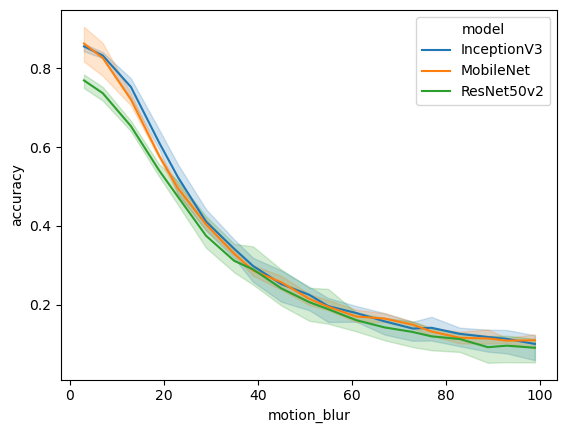

In [182]:
params = np.array(list(map(lambda x: x if x%2==1 else x-1, np.linspace(3,100,19).astype(int))))

transforms_list = [A.MotionBlur(blur_limit=(i, i), allow_shifted=False, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'motion_blur'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(transforms['name']+'.csv')

#### Downscale

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 11.072402381896973, Accuracy: 0.07246376574039459
	Transform 2/19:
		Loss: 10.831155681610108, Accuracy: 0.07246376574039459
	Transform 3/19:
		Loss: 11.66577968597412, Accuracy: 0.08695652335882187
	Transform 4/19:
		Loss: 13.108734512329102, Accuracy: 0.06521739065647125
	Transform 5/19:
		Loss: 11.976847934722901, Accuracy: 0.05797101557254791
	Transform 6/19:
		Loss: 9.130767631530762, Accuracy: 0.06521739065647125
	Transform 7/19:
		Loss: 9.784976482391357, Accuracy: 0.021739130839705467
	Transform 8/19:
		Loss: 11.475317478179932, Accuracy: 0.007246376946568489
	Transform 9/19:
		Loss: 9.132146644592286, Accuracy: 0.014492753893136978
	Transform 10/19:
		Loss: 7.328085851669312, Accuracy: 0.10869564861059189
	Transform 11/19:
		Loss: 6.3353251934051515, Accuracy: 0.15217390656471252
	Transform 12/19:
		Loss: 4.865072774887085, Accuracy: 0.260869562625885
	Transform 13/19:
		Loss: 3.6155114650726317, Accuracy

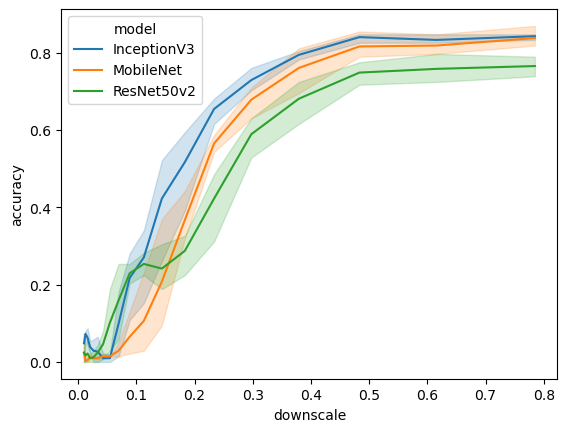

In [198]:
params = np.logspace(-2,0,19,endpoint=False)

transforms_list = [A.Downscale(scale_min=i, scale_max=i, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'downscale'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(transforms['name']+'.csv')

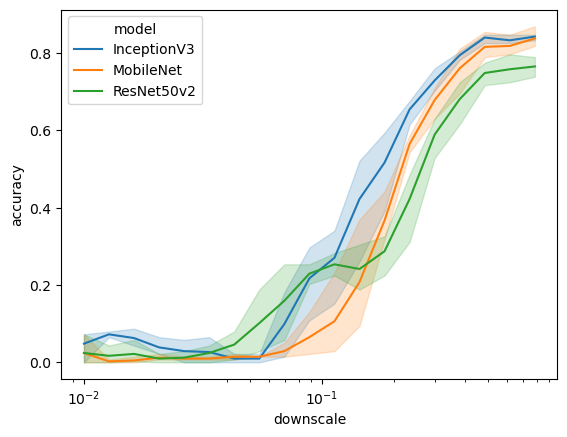

In [199]:
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

<Axes: xlabel='motion_blur', ylabel='accuracy'>

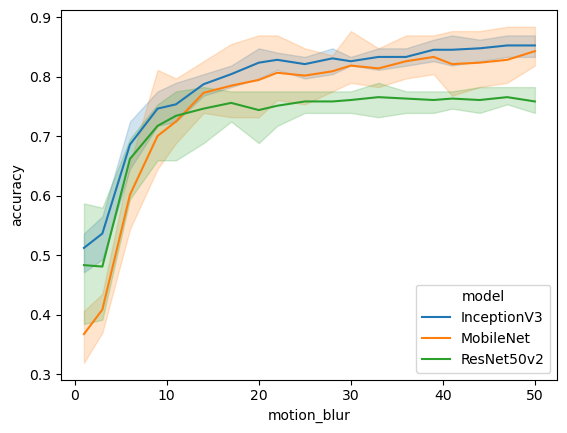

In [149]:

sns.lineplot(data=df, x='motion_blur', y='accuracy', hue='model')


In [135]:
xd = nature_ds.map(prepare_mapping(A.GaussianBlur())).prefetch(tf.data.AUTOTUNE)
def set_shapes(img, label, img_shape=(224,224,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

xd = xd.map(set_shapes).batch(32).prefetch(tf.data.AUTOTUNE)
display(nature_ds)
display(xd)
model.evaluate(xd)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

5/5 [==============================] - 9s 1s/step - loss: 0.7119 - accuracy: 0.8551


[0.7118556499481201, 0.8550724387168884]

ISONoise, Downscale, ImageCompression, MotionBlur

## Augmentation

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 17, 22, 28, 36, 46, 60, 78, 100]
Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:


c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 3.7743399143218994, Accuracy: 0.47101449966430664
	Transform 2/19:
		Loss: 3.7575035095214844, Accuracy: 0.47826087474823
	Transform 3/19:
		Loss: 3.7096664905548096, Accuracy: 0.49275362491607666
	Transform 4/19:
		Loss: 2.7711338996887207, Accuracy: 0.5652173757553101
	Transform 5/19:
		Loss: 2.6726787090301514, Accuracy: 0.6086956858634949
	Transform 6/19:
		Loss: 2.142667770385742, Accuracy: 0.6449275612831116
	Transform 7/19:
		Loss: 1.8413561582565308, Accuracy: 0.6666666865348816
	Transform 8/19:
		Loss: 1.6849761009216309, Accuracy: 0.7101449370384216
	Transform 9/19:
		Loss: 1.4956361055374146, Accuracy: 0.717391312122345
	Transform 10/19:
		Loss: 1.422515630722046, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.2002360820770264, Accuracy: 0.7898550629615784
	Transform 12/19:
		Loss: 1.0577759742736816, Accuracy: 0.8188406229019165
	Transform 13/19:
		Loss: 0.9691286087036133, Accuracy: 0.8405797481536865
	Transform 14/19:
		Loss: 0.8451421856880188, Accuracy:

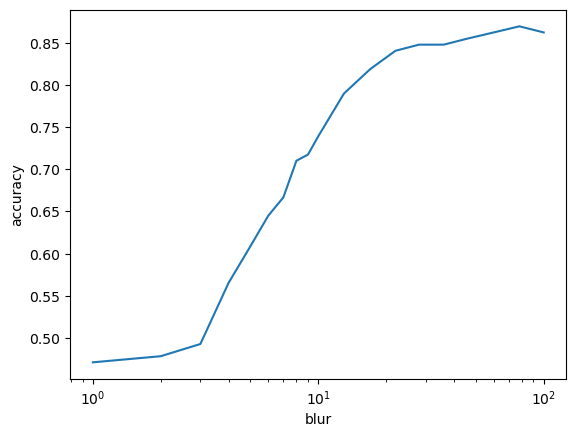

In [7]:
c = [1,2,3,4,5,6,7,8,9,10,13,17,22,28,36,46,60,78,100]
print(c)
x = test_transformed(model_paths[0:1],{'list':[A.ImageCompression(quality_lower=i, quality_upper=i,p=1) for i in c] ,'parameters':c, 'name':'blur'},ds,1)
x=pd.DataFrame(x)
sns.lineplot(data=x, x='blur',y='accuracy')
plt.xscale('log')

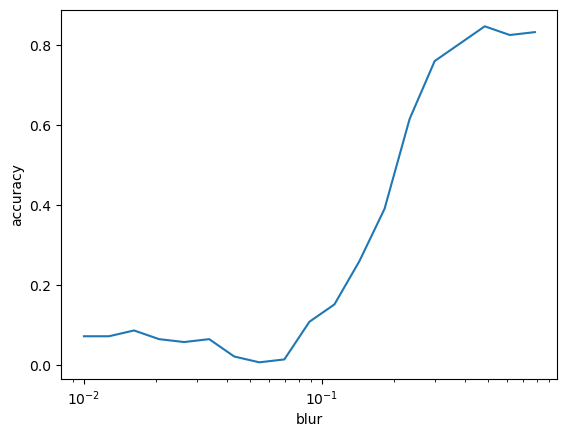

In [195]:
sns.lineplot(data=x, x='blur',y='accuracy')
plt.xscale('log')

c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


(224, 224, 3) 1


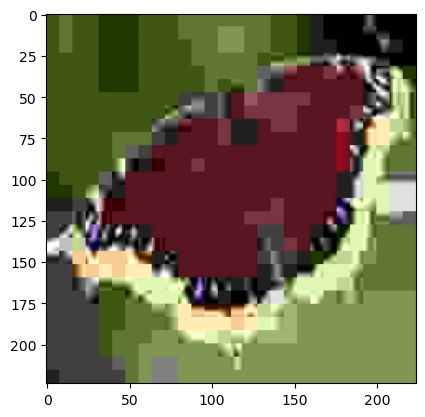

(224, 224, 3) 2


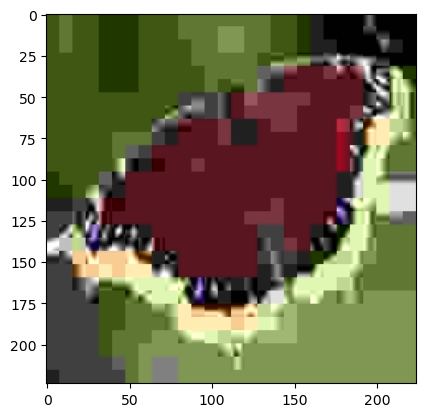

(224, 224, 3) 3


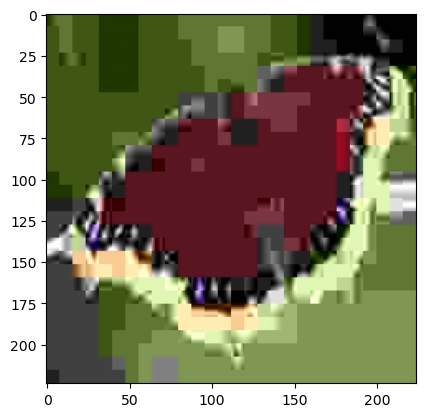

(224, 224, 3) 4


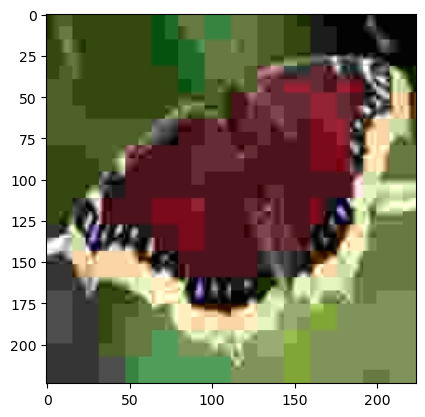

(224, 224, 3) 5


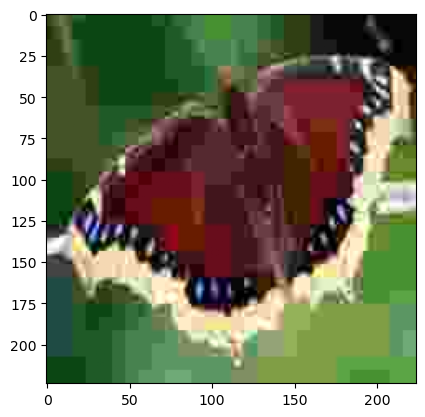

(224, 224, 3) 6


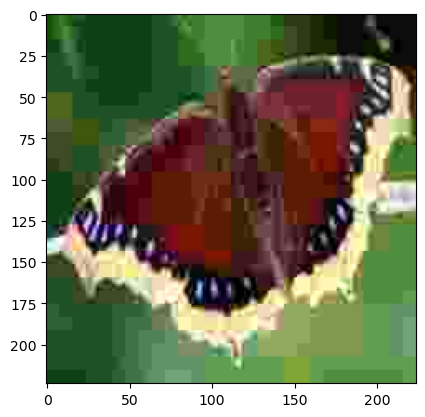

(224, 224, 3) 7


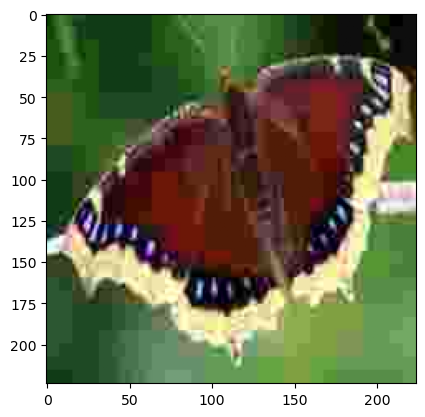

(224, 224, 3) 8


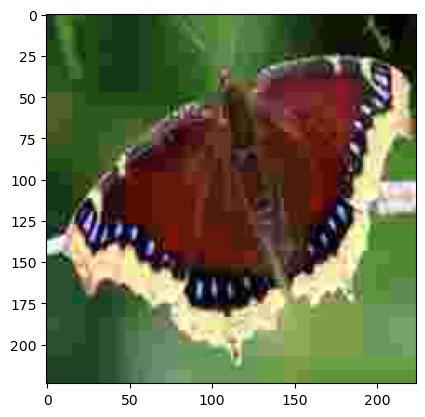

(224, 224, 3) 9


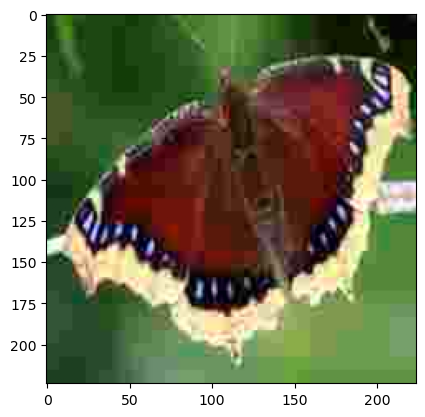

(224, 224, 3) 10


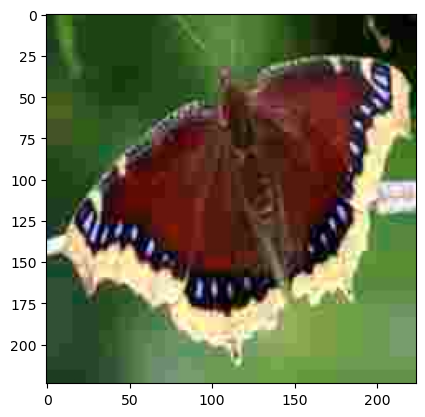

(224, 224, 3) 13


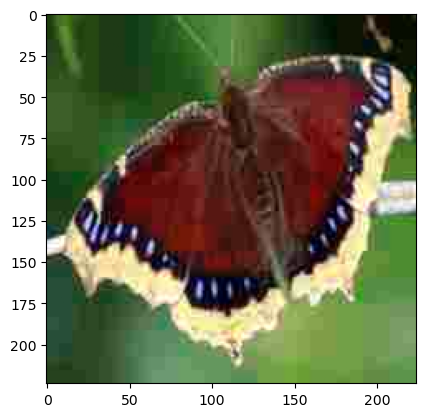

(224, 224, 3) 17


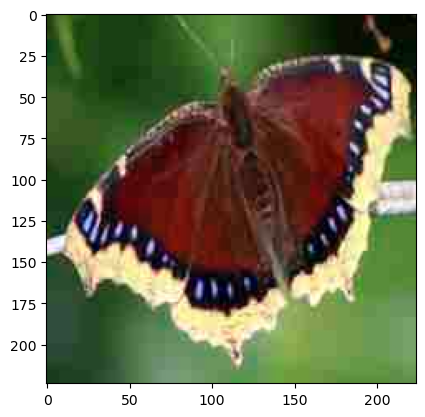

(224, 224, 3) 22


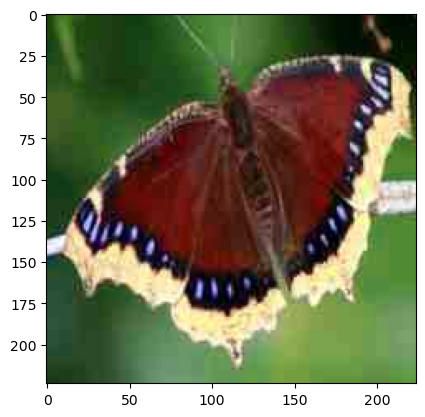

(224, 224, 3) 28


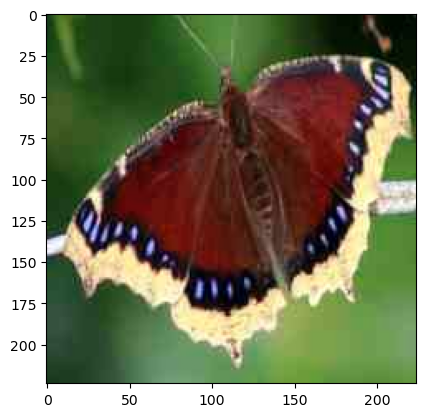

(224, 224, 3) 36


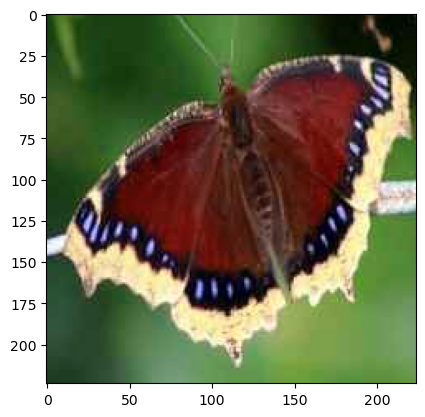

(224, 224, 3) 46


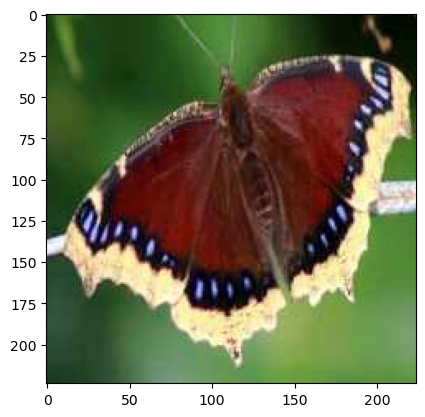

(224, 224, 3) 60


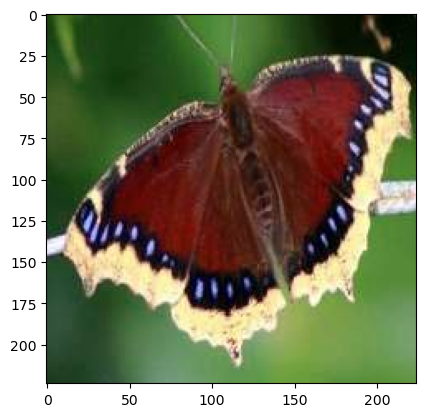

(224, 224, 3) 78


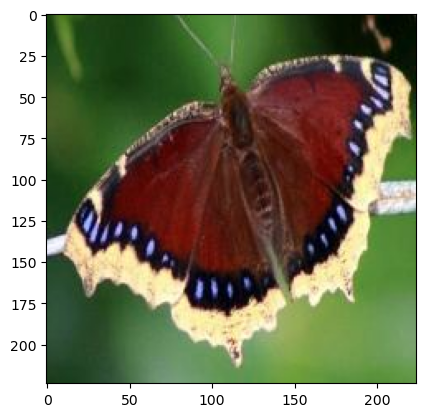

(224, 224, 3) 100


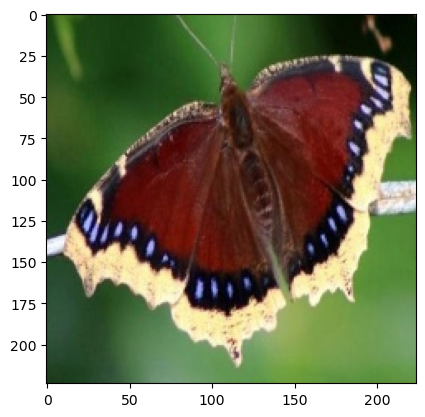

In [8]:
i = [1,2,3,4,5,6,7,8,9,10,13,17,22,28,36,46,60,78,100]
for j in i:
    transforms = A.Compose([A.ImageCompression(j,j,p=1)])
    def aug_fn(image):
        data = {'image': image}
        aug_data = transforms(**data)
        aug_img = aug_data['image']
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label
    img = plt.imread('kaggle dataset/nymphalis antiopa/0005.jpg')
    img2 = aug_fn((img/255).astype(np.float32))
    print(img2.shape, j)
    plt.imshow(img2)
    plt.show()

4030.3496704396384 0.06198154049119012


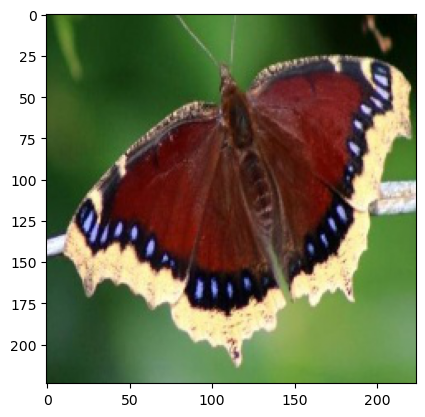

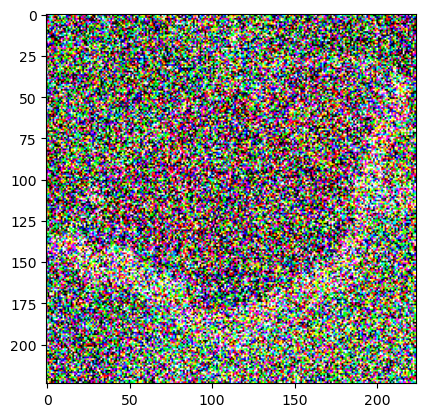

In [19]:
img = plt.imread('kaggle dataset/nymphalis antiopa/0005.jpg')
print(img.var(), (img/255).var())
plt.imshow(img/255)
plt.show()

img2 = aug_fn((img/255).astype(np.float32))
plt.imshow(img2)
plt.show()

In [21]:
img2 < 0

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

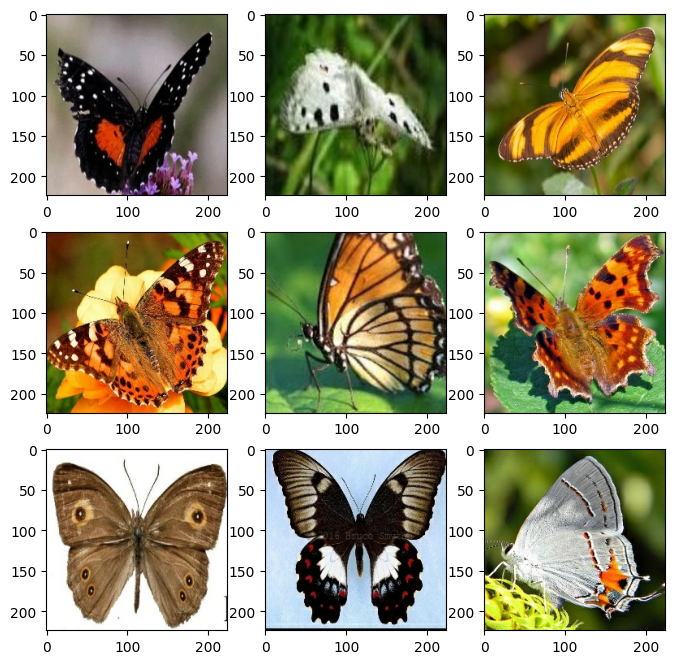

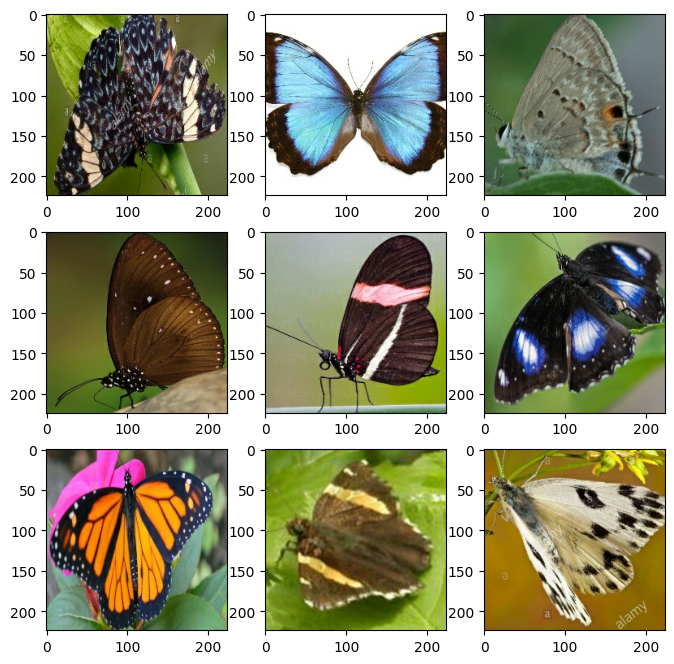

In [6]:
plt.figure(figsize=(8,8))
x = list(train_ds.take(1))
for i, l in x:
    for itr in range(9):
        plt.subplot(3,3,itr+1)
        plt.imshow(i[itr].numpy())

plt.show()

plt.figure(figsize=(8,8))
x = list(train_ds.map(process_data).prefetch(tf.data.AUTOTUNE).take(1))
for i, l in x:
    for itr in range(9):
        plt.subplot(3,3,itr+1)
        plt.imshow(i[itr].numpy())

plt.show()

In [19]:
#model = tf.keras.models.load_model(f'{FPATH}/ResNet50v2_(2023-03-25)_0/model')
a, l = model.evaluate(test_ds)
a2, l2 = model.evaluate(test_ds.map(process_data).prefetch(tf.data.AUTOTUNE))
print(a,l)
print(a2,l2)

48/48 [==============================] - 26s 239ms/step - loss: 9.9634 - accuracy: 0.4948
0.1470971703529358 0.9772135615348816
9.963364601135254 0.4947916865348816


In [22]:
dir = pathlib.Path('D:/Master thesis/saved_models')
for p in dir.glob('*'):
    try:
        with open(str(p)+'\\info.json') as src:
            info = json.load(src)
            print(p.name)
            print(f"\tKaggle: {info['test_accuracy']}, nature: {info['nature_accuracy']}")
    except:
        print(f'{p.name} has no info file')
        

MobileNetV2_(2023-03-24)_0
	Kaggle: 0.9596354365348816, nature: 0.8115942478179932
MobileNet_(2023-03-23)_0
	Kaggle: 0.9752604365348816, nature: 0.8333333730697632
ResNet50v2_(2023-03-25)_0
	Kaggle: 0.9654948115348816, nature: 0.760869562625885
ResNet_(2023-03-22)_1
	Kaggle: 0.9680989980697632, nature: 0.782608687877655
VGG16_(2023-03-16)_0
	Kaggle: 0.9075521230697632, nature: 0.7681159377098083
VGG16_(2023-03-16)_1
	Kaggle: 0.927734375, nature: 0.695652186870575
VGG16_(2023-03-16)_2
	Kaggle: 0.9420573115348816, nature: 0.7028985619544983
VGG16_(2023-03-16)_3
	Kaggle: 0.9309896230697632, nature: 0.7028985619544983
VGG16_(2023-03-17)_0
	Kaggle: 0.9498698115348816, nature: 0.7536231875419617
VGG16_(2023-03-17)_1
	Kaggle: 0.9440104365348816, nature: 0.7318840622901917
VGG16_(2023-03-17)_2 has no info file
VGG16_(2023-03-17)_3
	Kaggle: 0.9322916865348816, nature: 0.7463768124580383
VGG16_(2023-03-18)_0 has no info file
VGG16_(2023-03-18)_1
	Kaggle: 0.9140625, nature: 0.695652186870575
VGG1

In [4]:
chosen_models = ['VGG16_(2023-03-20)_0', 'VGG19_(2023-03-20)_0', 'ResNet_(2023-03-22)_1', 'ResNet50v2_(2023-03-25)_0', 'MobileNet_(2023-03-23)_0', 'MobileNetV2_(2023-03-24)_0']
paths = [f'{FPATH}/{p}' for p in chosen_models]


In [ ]:

noised_test = test_ds.map(process_data).prefetch(tf.data.AUTOTUNE)
for p in paths:
    model = tf.keras.models.load_model(p + '/model')
    l, a = model.evaluate(noised_test)
    with open(p + '/info.json') as src1:
        info = json.load(src1)
        info['noised_loss'] = l
        info['noised_accuracy'] = a
        
        with open(p + '/info.json', 'w') as src2:
            json.dump(info, src2)
        
tf.keras.applications.mobi

Model: VGG16
Time: 9182.725998878479
Epochs: 100
T/E: 91.82725998878479
Accuracy:
 kaggle: 0.9420573115348816, nature: 0.7681159377098083, noised: 0.4583333432674408


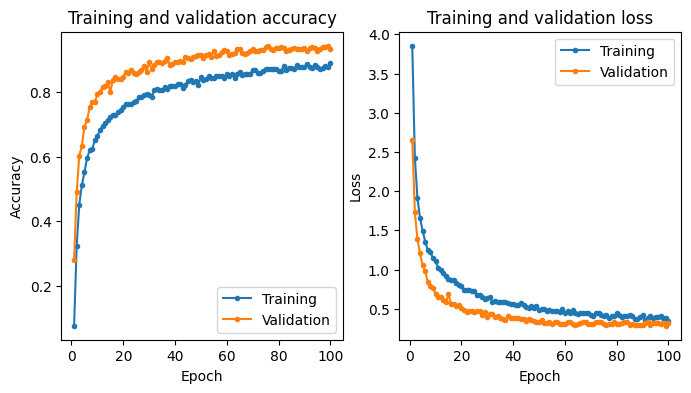

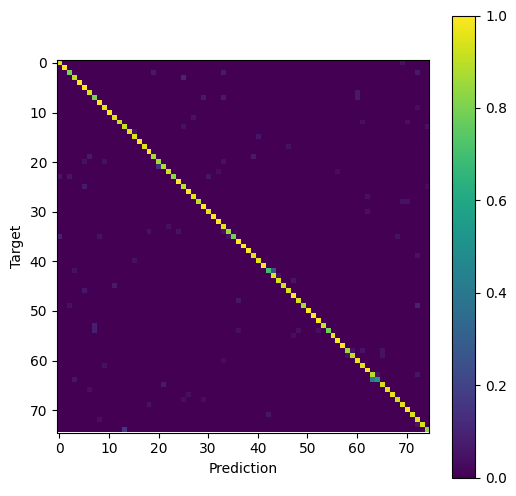

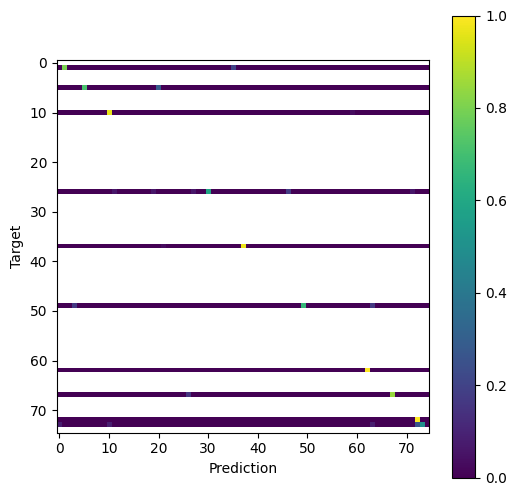

Model: VGG19
Time: 11790.862979412079
Epochs: 100
T/E: 117.90862979412078
Accuracy:
 kaggle: 0.9173177480697632, nature: 0.760869562625885, noised: 0.4505208432674408


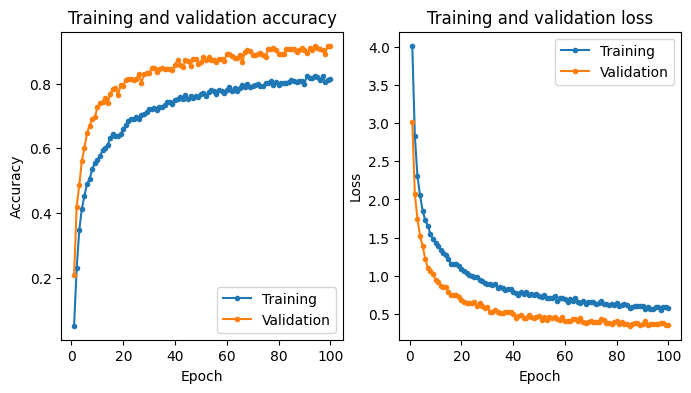

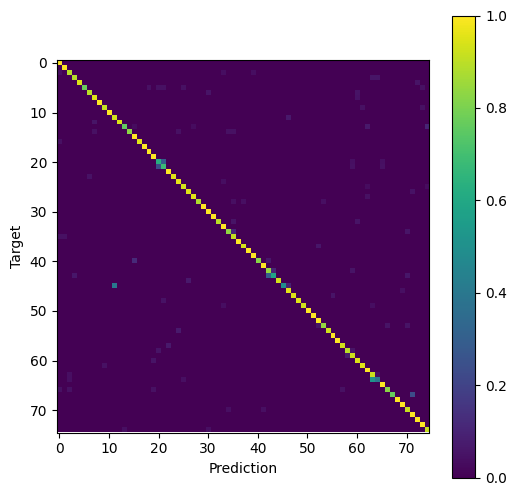

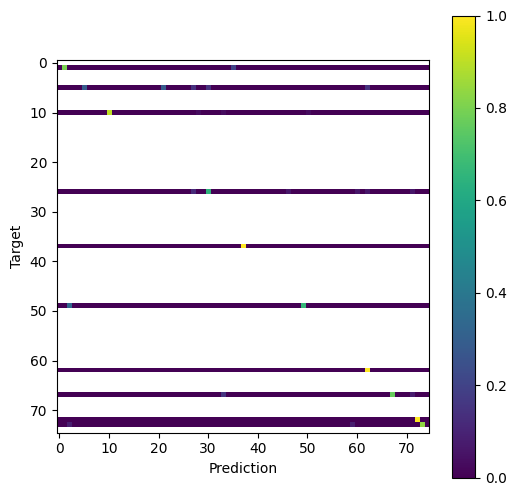

Model: ResNet
Time: 11135.328214406967
Epochs: 50
T/E: 222.70656428813933
Accuracy:
 kaggle: 0.9680989980697632, nature: 0.782608687877655, noised: 0.513671875


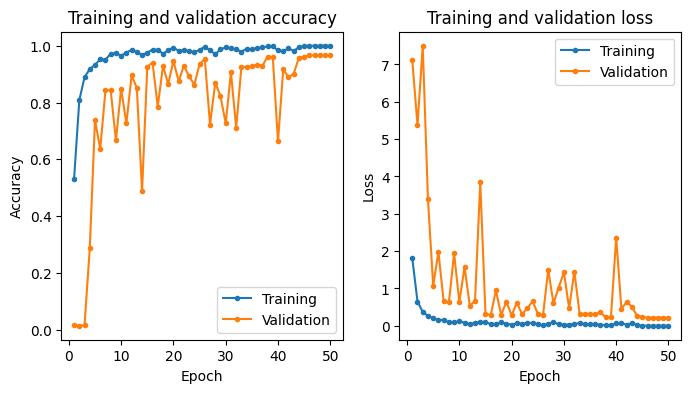

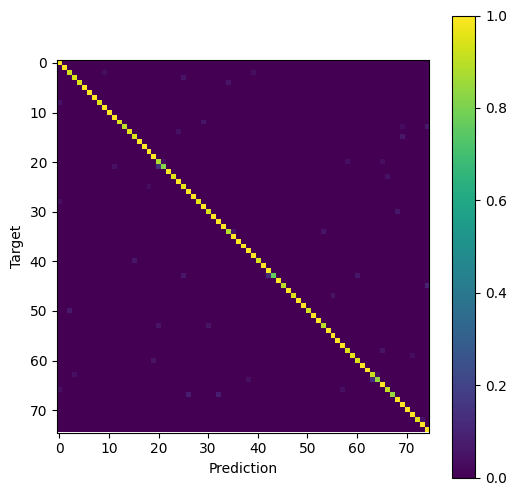

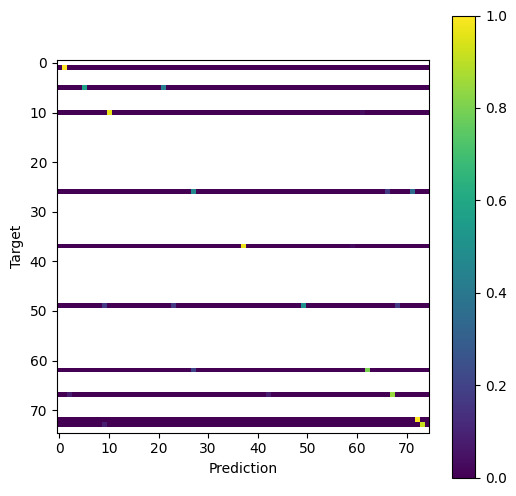

Model: ResNet50v2
Time: 27420.117421388626
Epochs: 100
T/E: 274.20117421388625
Accuracy:
 kaggle: 0.9654948115348816, nature: 0.760869562625885, noised: 0.4583333432674408


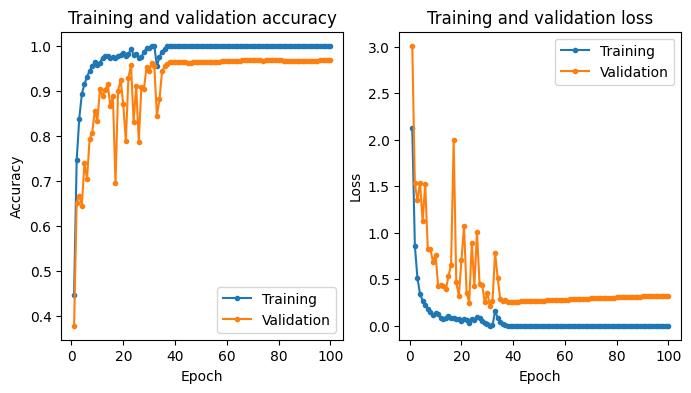

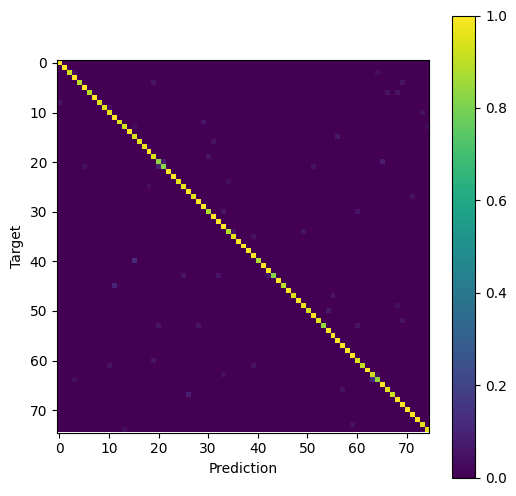

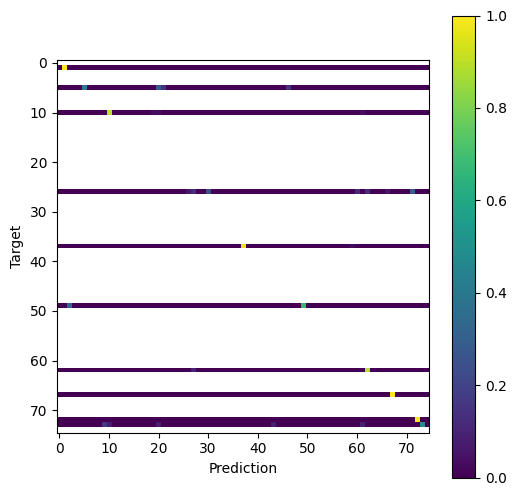

Model: MobileNet
Time: 8664.782270669937
Epochs: 100
T/E: 86.64782270669937
Accuracy:
 kaggle: 0.9752604365348816, nature: 0.8333333730697632, noised: 0.4134114682674408


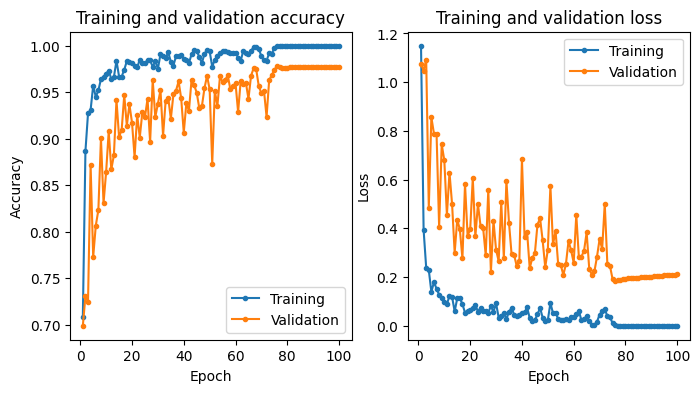

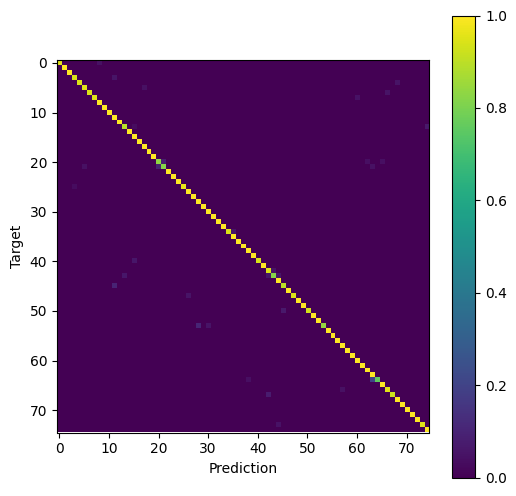

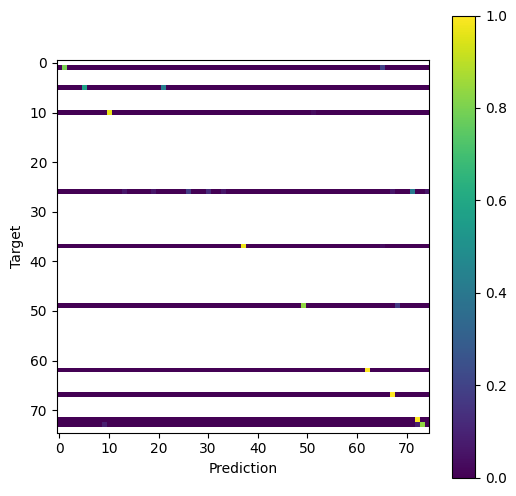

Model: MobileNetV2
Time: 67005.59485816956
Epochs: 100
T/E: 670.0559485816956
Accuracy:
 kaggle: 0.9596354365348816, nature: 0.8115942478179932, noised: 0.4674479365348816


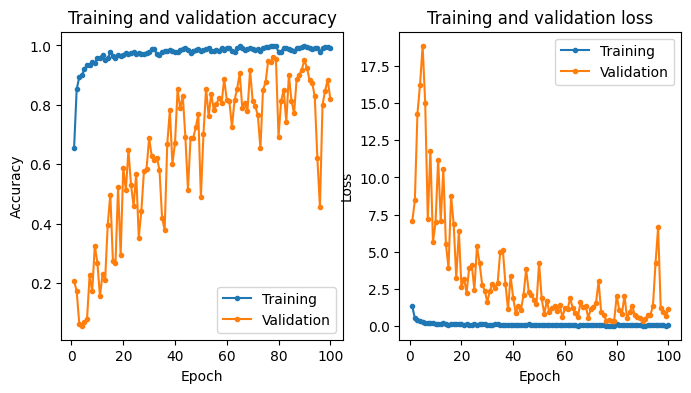

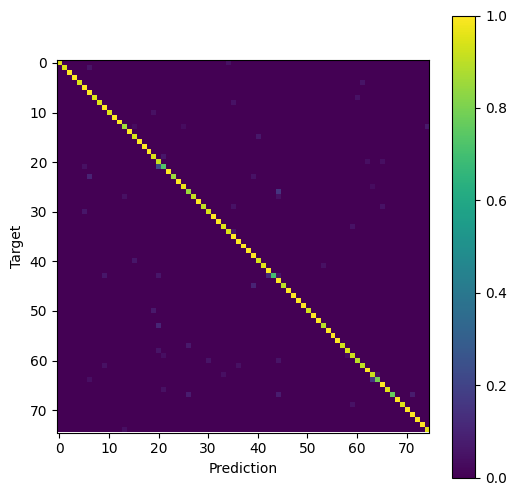

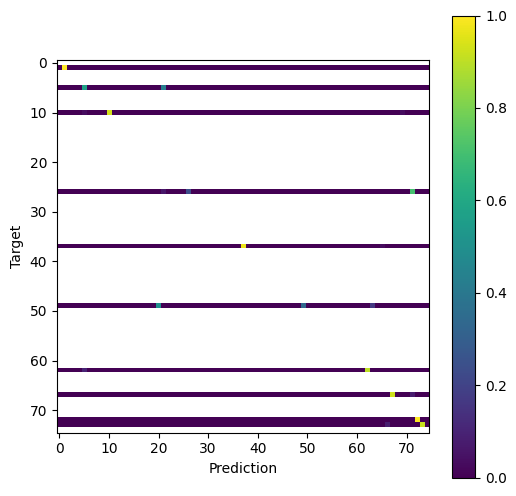

In [7]:
for p in paths:
    with open(p + '/info.json') as src1, open(p + '/history.json') as src2:
        info = json.load(src1)
        history = json.load(src2)
        class h:
            def __init__(self, his):
                self.history = his
        
    print(f"Model: {info['name']}")
    print(f"Time: {info['duration']}")
    try:
        print(f"Epochs: {info['epochs']}")
        print(f"T/E: {info['duration']/info['epochs']}")
    except:
        print()
    print(f"Accuracy:\n kaggle: {info['test_accuracy']}, nature: {info['nature_accuracy']}, noised: {info['noised_accuracy']}")
    tf_utils.plot_history(h(history))
    plt.show()
    tf_utils.plot_confusion_matrix(np.array(info['test_confusion']),figsize=(6,6))
    plt.show()
    tf_utils.plot_confusion_matrix(np.array(info['nature_confusion']),figsize=(6,6))
    plt.show()